# Goal
- Look at the [kaggle page](https://www.kaggle.com/laudanum/footballdelphi)
    - put into a SQL DB
- Information Needed
    - Name of the team
    - Total # of goals scored by the 2011 season
    - Total # of wins of the 2011 season team
    - Histogram viz of the team's win/loss for the 2011 season
    - Team's win percentage on the days it was raining during the game in 2011 season
    

# Getting Weather Data
* This is for the last sub-note taking mark mark under "Information Needed"
* Need weather Data to find the team's win percentage on rainy days

- Use [DarkSky API](https://darksky.net/dev) to get historical weather data
    - Use weather in Berlin, Germany as a proxy
    * If it was raining in Berlin on a game day, then count that as a rain game

In [208]:
import pandas as pd
import requests
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

In [161]:
# Creating a cursor for the soccer SQL DB
conn = sqlite3.connect("Data/soccer.sqlite")
cur = conn.cursor()

# Sum of the home team's home goals, and the away team's away goals
soccer_df = pd.read_sql_query("""
SELECT Date, HomeTeam, AwayTeam, SUM(FTAG) as away_goals, SUM(FTHG) as home_goals, FTR as who_won
FROM Matches
WHERE season LIKE 2011
GROUP BY HomeTeam
""", conn)


In [162]:
soccer_df.head()

,Date,HomeTeam,AwayTeam,away_goals,home_goals,who_won
0,2012-03-30,Aachen,Dresden,24,15,A
1,2011-08-20,Arsenal,Liverpool,17,39,A
2,2011-08-20,Aston Villa,Blackburn,25,20,H
3,2011-11-06,Augsburg,Bayern Munich,19,20,A
4,2011-11-19,Bayern Munich,Dortmund,6,49,A


# GOLAS TOTAL

In [143]:
# Finding the total score for TeamNames
goals_total_df = pd.read_sql_query("""
SELECT TeamName, SUM(FTHG + FTAG) as goals_total
FROM Unique_Teams ut 
LEFT JOIN Teams_in_Matches 
USING(Unique_Team_ID)
LEFT JOIN Matches
USING(Match_ID)
WHERE Season LIKE 2011
GROUP BY TeamName -- no dups
""", conn)

# HOME AND AWAY WINS

In [144]:
home_wins_df = pd.read_sql_query("""
SELECT HomeTeam as team, COUNT(FTR) as total_home_wins, Date
FROM Matches
WHERE Season LIKE 2011 AND FTR = "H"
GROUP BY HomeTeam -- no dups
""", conn)

In [145]:
# Finding total wins for away teams
away_wins_df = pd.read_sql_query("""
SELECT AwayTeam as team, COUNT(FTR) as total_away_wins, Date
FROM Matches
WHERE Season LIKE 2011 AND FTR = "A"
GROUP BY AwayTeam -- no dups
""", conn)

# HOME AND AWAY DRAWS

In [76]:
away_draws_df = pd.read_sql_query("""
SELECT AwayTeam as team, COUNT(FTR) as total_away_draws, Date
FROM Matches
WHERE Season LIKE 2011 AND FTR = "D"
GROUP BY AwayTeam -- no dups
""", conn)

In [77]:
home_draws_df = pd.read_sql_query("""
SELECT HomeTeam as team, COUNT(FTR) as total_home_draws, Date
FROM Matches
WHERE Season LIKE 2011 AND FTR = "D"
GROUP BY HomeTeam -- no dups
""", conn)

# HOME AND AWAY LOSS

In [78]:
# Finding home team total loss
home_loss_df = pd.read_sql_query("""
SELECT HomeTeam as team, COUNT(FTR) as home_loss, Data
FROM Matches
WHERE Season LIKE 2011 AND FTR = "A"
GROUP BY HomeTeam -- no dups
""", conn)

In [135]:
# Finding away team total loss
away_loss_df = pd.read_sql_query("""
SELECT AwayTeam as team, COUNT(FTR) as away_loss, Date
FROM Matches
WHERE Season LIKE 2011 AND FTR = "H"
GROUP BY AwayTeam -- no dups
""", conn)

# TOTAL LOSS

In [136]:
total_loss = away_loss_df.away_loss + home_loss_df.home_loss

In [137]:
total_loss = pd.DataFrame(total_loss)
total_loss.head()

,0
0,15.0
1,10.0
2,14.0
3,12.0
4,7.0


# DATES

In [236]:
home_dates_df = pd.read_sql_query("""
SELECT Date as date
FROM Matches
WHERE Season LIKE 2011
GROUP BY HomeTeam -- no dups
""", conn)

In [241]:
home_dates_df.date = pd.to_datetime(home_dates_df.date) # Converting the date column to a datetime format
home_dates_df.head()

,date
0,2012-03-30
1,2011-08-20
2,2011-08-20
3,2011-11-06
4,2011-11-19


In [238]:
away_dates_df = pd.read_sql_query("""
SELECT Date as date
FROM Matches
WHERE Season LIKE 2011
GROUP BY AwayTeam -- no dups
""", conn)

In [242]:
away_dates_df.date = pd.to_datetime(away_dates_df.date) # Converting the date column to a datetime format
away_dates_df.head()

,date
0,2011-11-20
1,2011-08-13
2,2011-08-13
3,2011-08-27
4,2012-03-31


# Combining Date

In [163]:
game_dates = pd.merge(home_dates_df, away_dates_df)

# TEAM INFO ON TEAM NAMES AND WINS AND LOSS

In [138]:
team_info = pd.merge(left=away_wins_df, right=home_wins_df)

In [139]:
team_wins = team_info.sum(axis=1)

In [167]:
team_info["team_wins"] = team_wins # Creating a new column called team_wins, giving it the value of team_wins 
team_info['team_loss'] = total_loss # Creating a new column called team_loss, giving it the value of total_loss 
team_info["date"] = dates_df # Creating a new column called date, giving it a value of the dates_df
team_info.dropna() # Dropping rows that have NaN

,team,total_away_wins,total_home_wins,team_wins,team_loss,date
0,Aachen,2,4,6,15.0,2012-03-30
1,Arsenal,9,12,21,10.0,2011-08-20
2,Aston Villa,3,4,7,14.0,2011-08-20
3,Augsburg,2,6,8,12.0,2011-11-06
4,Bayern Munich,9,14,23,7.0,2011-11-19
5,Blackburn,2,6,8,23.0,2011-08-13
6,Bochum,3,7,10,17.0,2012-03-02
7,Bolton,6,4,10,22.0,2011-08-21
8,Braunschweig,4,6,10,9.0,2011-10-22
9,Chelsea,6,12,18,10.0,2011-08-20


# Histogram that uses win/loss for the 2011 season

Text(0.5, 1.0, 'Win Loss')

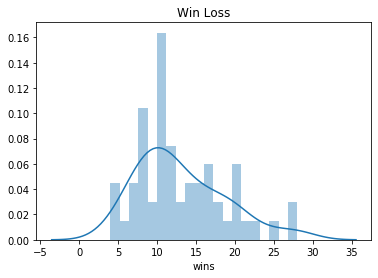

In [118]:
# Histogram of the team's win/loss for the 2011 season Using seaborn
sns.distplot(team_info.team_wins, bins=20, axlabel="wins").set_title("Win Loss")

# Using the DarkSky Api

In [282]:
from important_keys import apiKey

ModuleNotFoundError: No module named 'important_keys'

In [280]:
# Getting the weather through the DarkSky API

# Creating a class for getting DarkSky info
class GettingWeather():
    
    # Constructor that initiazlizes our get request and param requirements
    def __init__(self):
        self.api_key = important_keys.apiKey()
        self.berlin_latitude = "52.5200"
        self.berlin_longitude = "-13.4050"
        self.darkSky = requests.get(f"https://api.darksky.net/forecast/{api_key}/{berlinLatitude},{berlinLongitude}")
        
GettingWeather()

NameError: name 'important_keys' is not defined